In [323]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
import arviz as az
import pymc as pm
import seaborn as sns

from REStats.utils import load_SCADA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import statsmodels.api as sm

In [2]:
# cmap = mpl.colormaps['tab10']
sns.set_theme()

In [4]:
wt = load_SCADA(2020)

# Wind -> Wind

This approach takes advantage of the fact that wind speeds follow a Weibull distribution. By fitting the curve to find the shape $\alpha$ and scale $\beta$ parameters, we can apply a transformation to make the curve more Gaussian, after which we can standardize the data as before.

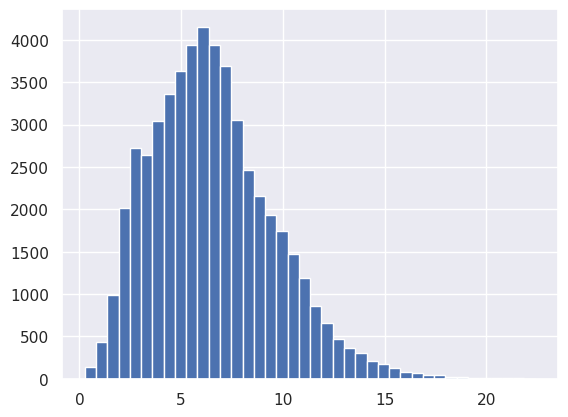

In [8]:
fig, ax = plt.subplots()

d = ax.hist(wt["Wind speed"], bins=40)

In [9]:
wt_1m = wt[(wt.index >= "2020-02-01") & (wt.index < "2020-03-01")]

ws = wt_1m["Wind speed"]

In [10]:
ws.isnull().sum() == 0, len(ws)

(True, 4176)

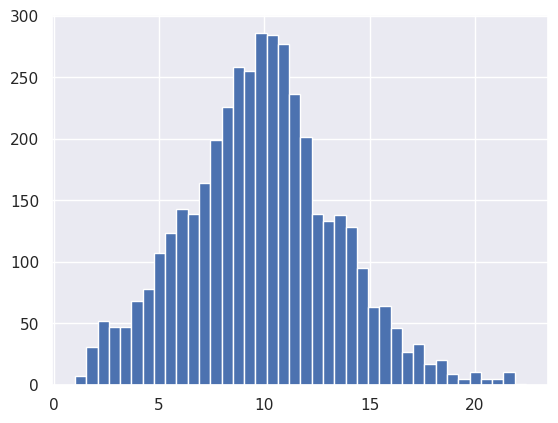

In [11]:
fig, ax = plt.subplots()

d = ax.hist(ws, bins=40)

## Processing: Weibull fit

In [12]:
with pm.Model() as model_wb:
    alpha = pm.Normal("alpha", 2, 2) # fairly informative priors
    sigma = pm.Normal("sigma", 10, 3)
    y = pm.Weibull("y", alpha, sigma, observed=ws.values)
    
    idata_wb = pm.sample()
    pm.sample_posterior_predictive(idata_wb, extend_inferencedata=True)
    pm.compute_log_likelihood(idata_wb)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
Sampling: [y]


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

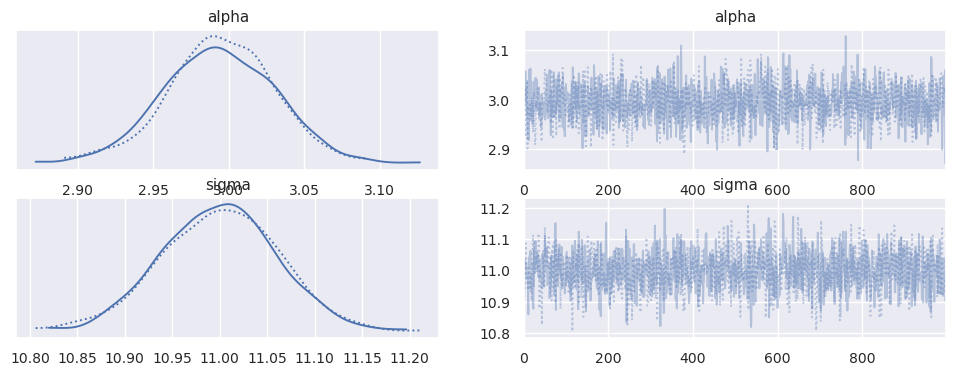

In [13]:
az.plot_trace(idata_wb)

In [14]:
az.loo(idata_wb)

Computed from 2000 posterior samples and 4176 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -11212.65    44.77
p_loo        2.24        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     4176  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

<Axes: xlabel='y / y'>

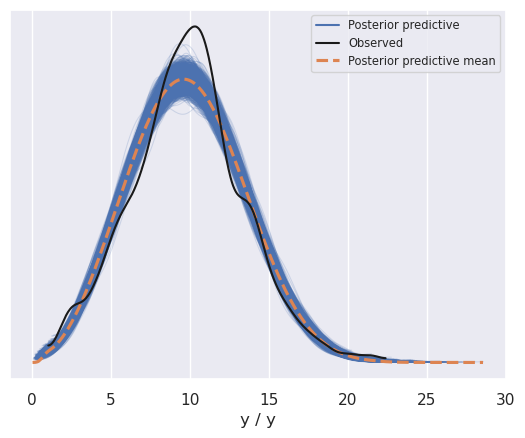

In [15]:
az.plot_ppc(idata_wb)

In [335]:
shape = idata_wb.posterior.alpha.mean(["chain", "draw"]).item(0)
scale = idata_wb.posterior.sigma.mean(["chain", "draw"]).item(0)

m = shape / 3.6

print(f"m: {m}")

m: 0.8316878934589049


We can use the fitted Weibull distribution's shape parameter $\alpha$ to apply a transform to our wind speed data $V$ to make it more Gaussian,

$$
\hat{V} = V^m
$$

where

$$
m = \frac{\alpha}{3.6}
$$

Why 3.6? This is the shape parameter corresponding to a Weibull distribution with Gaussian shape.

## Processing: transforms

In [336]:
def transform(v, m):
    v_scaled = v**m
    hr_group = v_scaled.groupby(v_scaled.index.hour)
    hr_mean, hr_std = hr_group.mean(), hr_group.std()
    
    df = pd.DataFrame({"v": v.values, "v_scaled": v_scaled.values}, index=v_scaled.index)
    df["hr"] = df.index.hour
    df["v_scaled_std"] = df.apply(lambda x: (x.v_scaled - hr_mean[x.hr])/hr_std[x.hr], axis=1)
    
    return df, (hr_mean, hr_std)

In [337]:
def inverse_transform(v_df, m, hr_stats):
    hr_mean, hr_std = hr_stats
    
    v_df["hr"] = v_df.index.hour

    inv_std =  v_df.apply(lambda x: x * hr_std[x.hr] + hr_mean[x.hr], axis=1)
    
    return inv_std**(1/m)

In [338]:
from numpy.testing import assert_array_almost_equal

# test functions

vh = v.resample("H").mean()
v_tf, hr_stats = transform(vh, m)

v_tf["y"] = v_tf.v_scaled_std
v_inv = inverse_transform(v_tf, m, hr_stats)

assert_array_almost_equal(vh, v_inv.y)

## Modeling

Autoregressive Moving Average (ARMA) model:

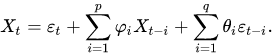

In [349]:
vh = ws.resample("H").mean()
v_tf, hr_stats = transform(vh, m)

v_tf.head()

,v,v_scaled,hr,v_scaled_std
Date,,,,
2020-02-01 00:00:00,9.675224,6.603320,0,0.146423
2020-02-01 01:00:00,9.348447,6.417299,1,0.036810
2020-02-01 02:00:00,8.373743,5.855730,2,-0.236439
2020-02-01 03:00:00,9.559914,6.537801,3,0.047023
2020-02-01 04:00:00,10.035535,6.807210,4,0.086797


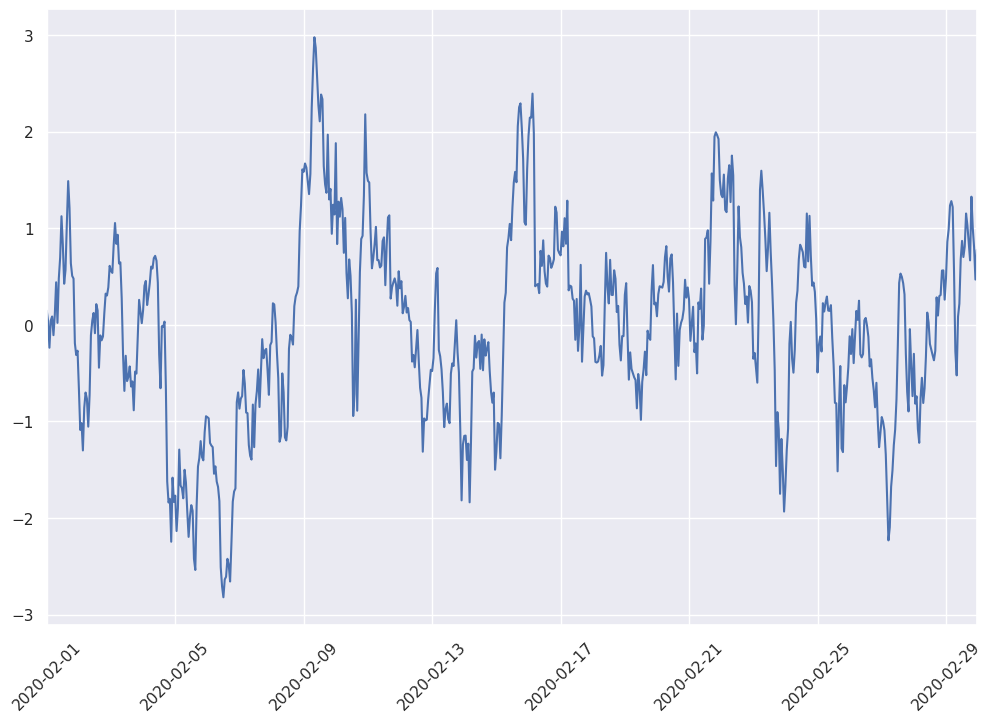

In [350]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.tick_params(axis='x', rotation=45)
ax.set_xmargin(0)
ax.plot(v_tf.index, v_tf.v_scaled_std)

(array([  8.,   8.,  24.,  29.,  53.,  73., 120., 100., 116.,  71.,  44.,
         25.,  14.,   8.,   3.]),
 array([-2.81953023, -2.43309467, -2.04665912, -1.66022356, -1.273788  ,
        -0.88735244, -0.50091689, -0.11448133,  0.27195423,  0.65838979,
         1.04482534,  1.4312609 ,  1.81769646,  2.20413202,  2.59056757,
         2.97700313]),
 <BarContainer object of 15 artists>)

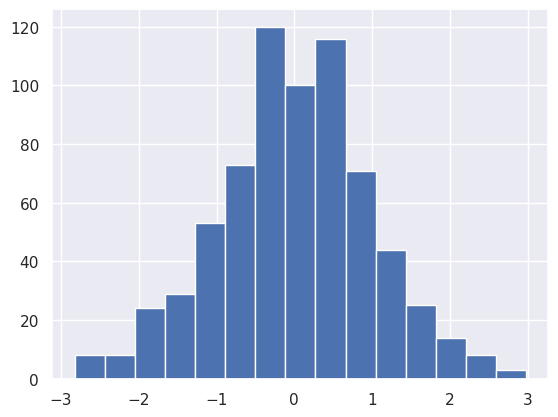

In [351]:
plt.hist(v_tf.v_scaled_std, bins=15)

In [352]:
arma_mod = ARIMA(v_tf.v_scaled_std, order=(2, 0, 2), trend="n")
arma_res = arma_mod.fit()
print(arma_res.summary())

                               SARIMAX Results                                
Dep. Variable:           v_scaled_std   No. Observations:                  696
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -247.785
Date:                Tue, 07 Mar 2023   AIC                            505.570
Time:                        01:18:02   BIC                            528.297
Sample:                    02-01-2020   HQIC                           514.358
                         - 02-29-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8350      0.758      1.101      0.271      -0.651       2.322
ar.L2          0.0969      0.706      0.137      0.891      -1.288       1.482
ma.L1          0.1224      0.761      0.161      0.8

In [353]:
pred = arma_res.get_prediction().summary_frame()
pred.head()

v_scaled_std,mean,mean_se,mean_ci_lower,mean_ci_upper
Date,,,,
2020-02-01 00:00:00,0.000000,0.975915,-1.912758,1.912758
2020-02-01 01:00:00,0.136945,0.345401,-0.540027,0.813918
2020-02-01 02:00:00,0.031938,0.345315,-0.644867,0.708743
2020-02-01 03:00:00,-0.221889,0.344934,-0.897947,0.454168
2020-02-01 04:00:00,0.061982,0.344926,-0.614060,0.738024


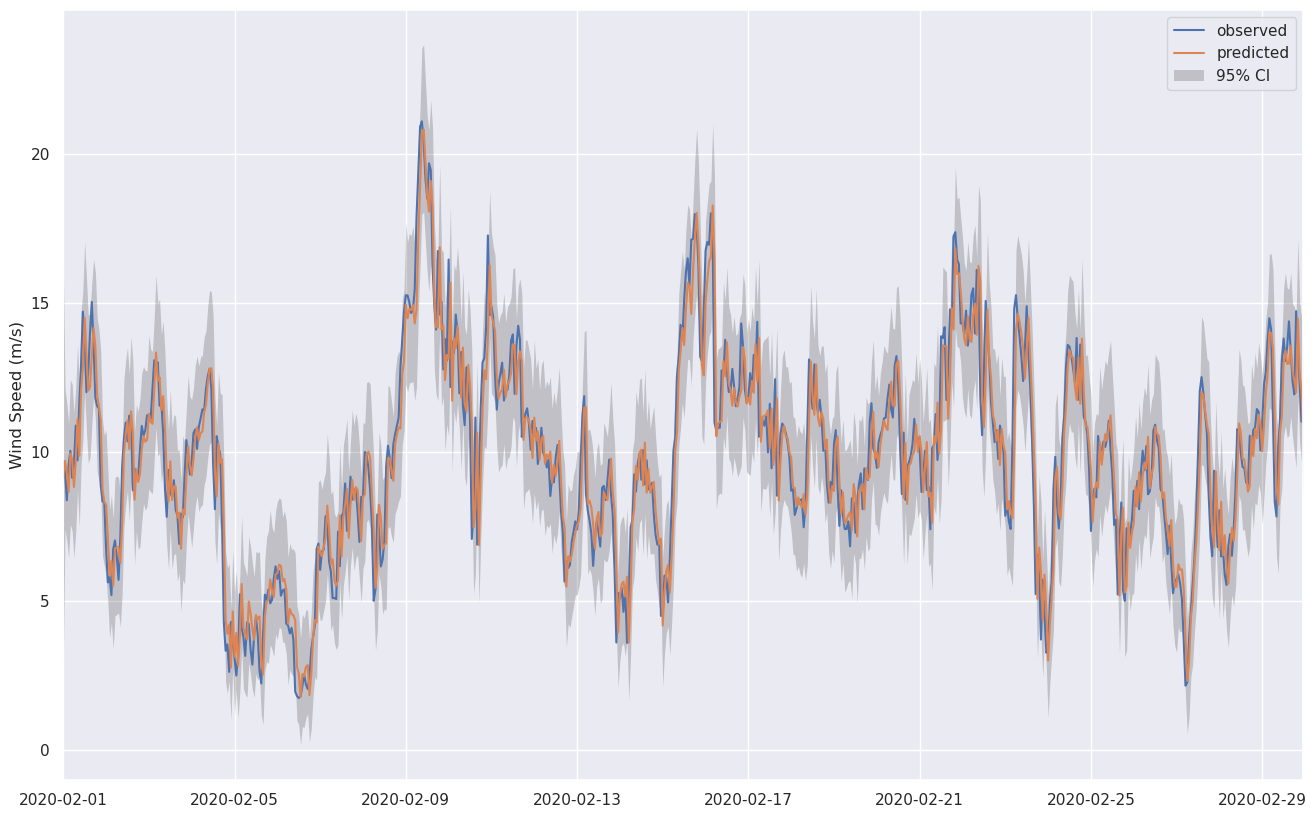

In [361]:
fig, ax = plt.subplots(figsize=(16, 10))

ax.set_xmargin(0)
ax.set_ylabel("Wind Speed (m/s)")

ax.plot(v_tf.index, v_tf.v, label="observed")

inv_df = inverse_transform(pred, m, hr_stats)
ax.plot(inv_df.index, inv_df["mean"], label="predicted")
ax.fill_between(
    inv_df.index, 
    inv_df.mean_ci_lower, 
    inv_df.mean_ci_upper, 
    color="k", alpha=.2, linewidth=0,
    label="95% CI"
)

ax.legend()


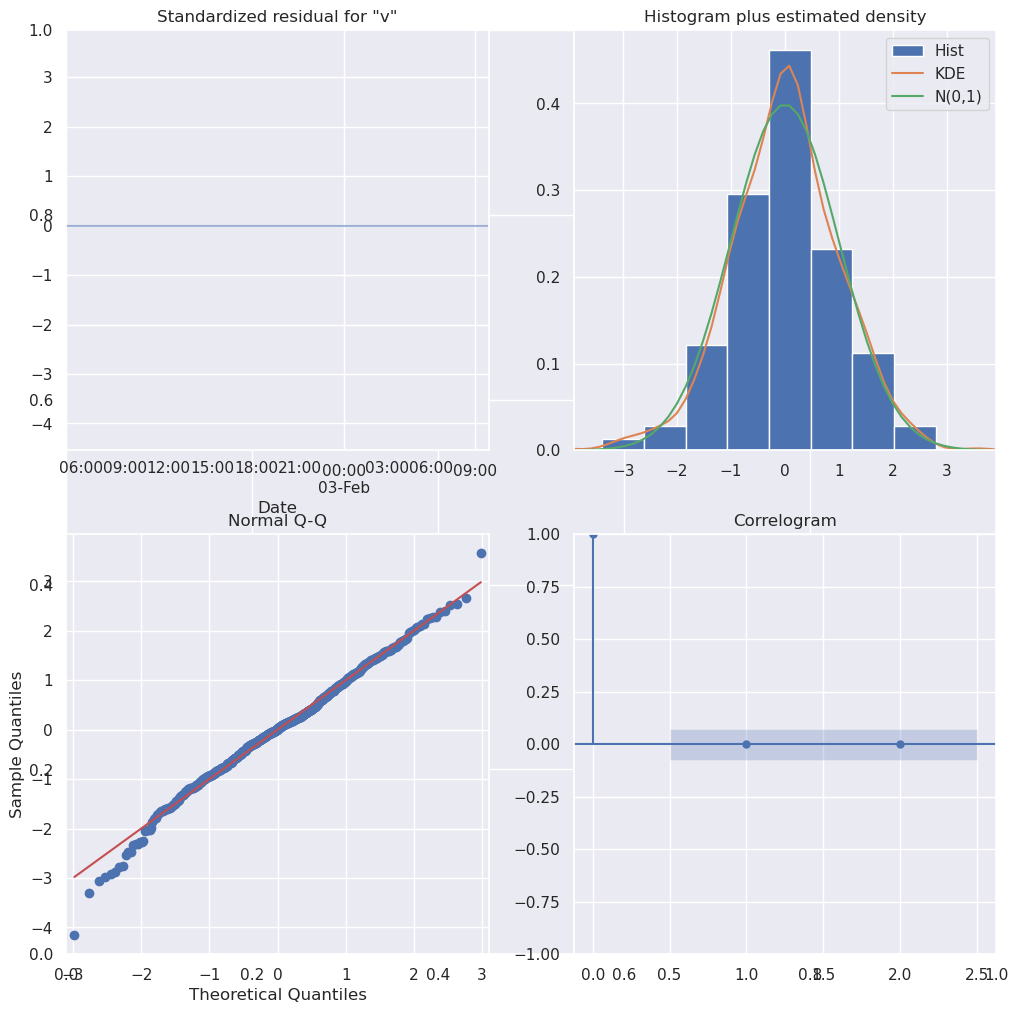

In [355]:
fig, ax = plt.subplots(figsize=(12, 12))

f = arma_res.plot_diagnostics(fig=fig, lags=2)

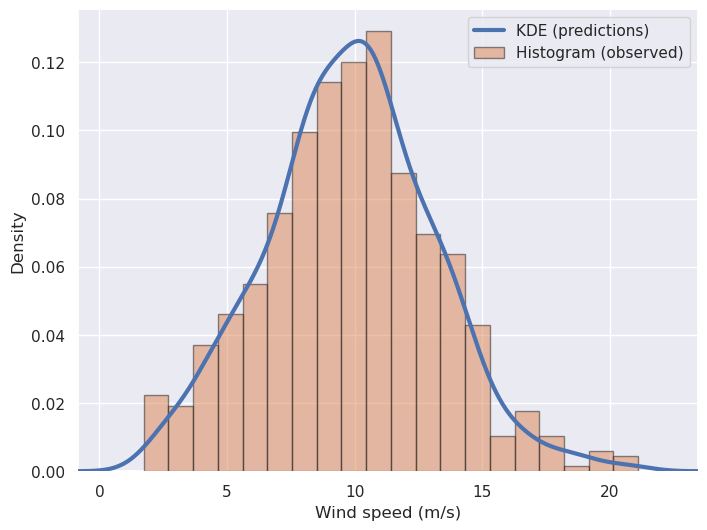

In [362]:
kde = sm.nonparametric.KDEUnivariate(inv_df["mean"])
kde.fit()  # Estimate the densities

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xmargin(0)
ax.set_xlabel("Wind speed (m/s)")
ax.set_ylabel("Density")

ax.plot(kde.support, kde.density, lw=3, label="KDE (predictions)", zorder=10)
ax.hist(
    v_tf.v,
    bins=20,
    density=True,
    label="Histogram (observed)",
    zorder=5,
    edgecolor="k",
    alpha=0.5,
)
ax.legend()

## Forecast

In [357]:
forecast = arma_res.get_forecast(steps=4)
forecast_res = forecast.summary_frame()
forecast_res

v_scaled_std,mean,mean_se,mean_ci_lower,mean_ci_upper
2020-03-01 00:00:00,0.748974,0.344924,0.072936,1.425013
2020-03-01 01:00:00,0.684552,0.477532,-0.251393,1.620497
2020-03-01 02:00:00,0.644199,0.560158,-0.453691,1.742089
2020-03-01 03:00:00,0.604259,0.624689,-0.620108,1.828626


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

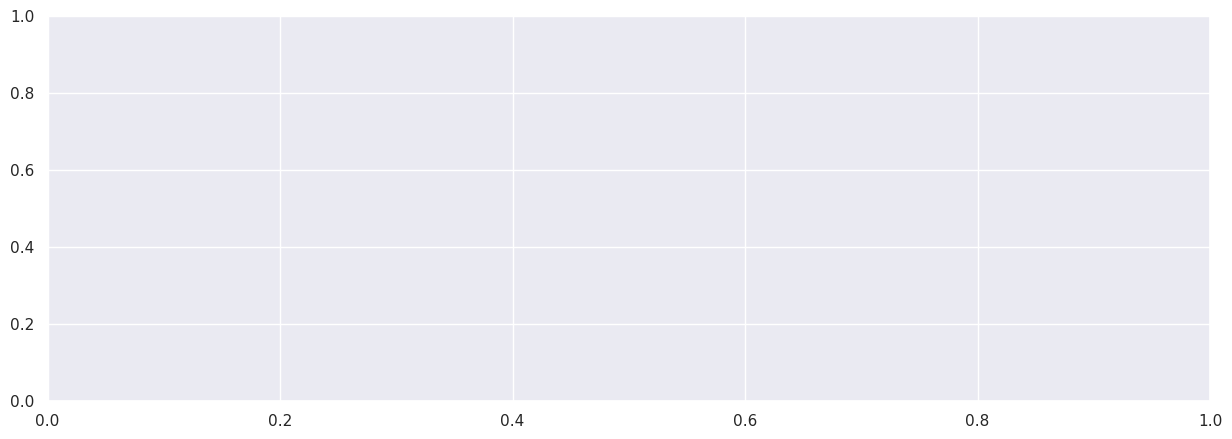

In [358]:
fig, ax = plt.subplots(figsize=(15, 5))

forecast_res = forecast.summary_frame()
v_12h = v_p[-12:]

ax.plot(range(len(v_12h)), v_12h)
forecast_res.index += 12

forecast_res['mean'].plot(ax=ax, style='k--')
ax.fill_between(forecast_res.index, forecast_res['mean_ci_lower'], forecast_res['mean_ci_upper'], color='k', alpha=0.1);